In [1]:
# imports some utilities ...
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

In [2]:
#defines routes

root_dir = "./"
data_dir = root_dir + "dataset/chest_xray/"

training_images_dir =  data_dir + "train/"
test_images_dir = data_dir + "test/"

training_images_dir

'./dataset/chest_xray/train/'

## Let's visualizate

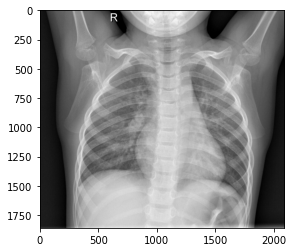

In [3]:
# Load an color image in grayscale
img = cv2.imread(training_images_dir + "/NORMAL/IM-0115-0001.jpeg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # RGB colorisation
plt.imshow(img_rgb)

In [4]:
def list_folders(startpath):
    """Print the folder sutructure of a given folder"""
    
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))

In [5]:
# defines class

categories = [
    ["NORMAL"],
    ["PNEUMONIA"]
]

In [6]:
type(img)
img_rgb.shape

(1858, 2090, 3)

In [7]:
from tensorflow.keras import layers, models
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# with tf.device('/GPU:0'):

input_size_1 = 64
input_size_2 = 64
dim = 3

kernel_size = (3, 3)
output_size = len(categories)
print("Output size :", output_size)

Num GPUs Available:  1
Output size : 2


## Datagen

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1/255
).flow_from_directory(
    training_images_dir,
    target_size=(input_size_1, input_size_2),
    color_mode="rgb",
    class_mode="binary",
    classes=["NORMAL", "PNEUMONIA"],
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 5216 images belonging to 2 classes.


In [9]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255
).flow_from_directory(
        test_images_dir,
        target_size=(input_size_1, input_size_2),
        color_mode="rgb",
        class_mode="binary",
        classes=["NORMAL", "PNEUMONIA"],
        batch_size=32,
        shuffle=True,
        seed=42
)

Found 624 images belonging to 2 classes.


1.0


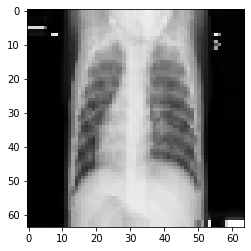

In [10]:
train_iter = iter(train_datagen)
train = train_iter.next()
print(train[1][0])
plt.imshow(train[0][0])

In [11]:
print("input size : ",input_size_1, input_size_2)
print("dim : ", dim)
print("kernel size : ", kernel_size)
output_size = output_size - 1 # For sigmoid activation its betwteen 0 and 1 
print("output size : ", output_size)


input size :  64 64
dim :  3
kernel size :  (3, 3)
output size :  1


In [12]:
def input_size_sequential(input_size_1, input_size_2, dim):
    return (input_size_1, input_size_2, dim)

In [13]:
input_size_sequential(input_size_1, input_size_2, dim)

(64, 64, 3)

In [14]:
# model = models.Sequential()

# model.add(layers.Conv2D(32, kernel_size = kernel_size, activation='relu', input_shape=input_size_sequential(input_size_1, input_size_2, dim)))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(layers.BatchNormalization())


# model.add(layers.Conv2D(64, kernel_size = kernel_size, activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(layers.BatchNormalization())


# model.add(layers.Conv2D(128, kernel_size = kernel_size, activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(layers.BatchNormalization())


# model.add(layers.Conv2D(256, kernel_size = (5, 5), activation='relu'))
# model.add(layers.BatchNormalization())

# model.add(layers.Flatten()) # 2d to 1d

# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.3))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dropout(0.3))
# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dropout(0.3))
# model.add(layers.Dense(output_size, activation='sigmoid'))

# model.summary()

In [15]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size = kernel_size, activation='relu', input_shape=input_size_sequential(input_size_1, input_size_2, dim)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Flatten()) # 2d to 1d

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(output_size, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 30752)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3936384   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,937,409
Trainable params: 3,937,409
Non-trainable params: 0
_________________________________________________________________


In [16]:
import tensorflow.keras as keras
optimizer = "adam"

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), ])

#  keras.metrics.TruePositives(), keras.metrics.FalsePositives(), keras.metrics.TrueNegatives(), keras.metrics.FalseNegatives()

In [17]:
epochs = 10
with tf.device('/GPU:0'):

    history = model.fit(train_datagen, epochs=epochs, 
                        validation_data=test_datagen)

Epoch 1/10
163/163 [==============================] - 50s 298ms/step - loss: 0.6450 - binary_accuracy: 0.7757 - recall: 0.9934 - auc: 0.6703 - val_loss: 0.3458 - val_binary_accuracy: 0.8574 - val_recall: 0.9410 - val_auc: 0.9396
Epoch 2/10
163/163 [==============================] - 48s 292ms/step - loss: 0.2634 - binary_accuracy: 0.8961 - recall: 0.9569 - auc: 0.9496 - val_loss: 0.3029 - val_binary_accuracy: 0.8798 - val_recall: 0.8744 - val_auc: 0.9477
Epoch 3/10
163/163 [==============================] - 46s 283ms/step - loss: 0.2563 - binary_accuracy: 0.8963 - recall: 0.9459 - auc: 0.9457 - val_loss: 0.3179 - val_binary_accuracy: 0.8606 - val_recall: 0.9564 - val_auc: 0.9460
Epoch 4/10
163/163 [==============================] - 46s 284ms/step - loss: 0.2089 - binary_accuracy: 0.9188 - recall: 0.9523 - auc: 0.9661 - val_loss: 0.3651 - val_binary_accuracy: 0.8221 - val_recall: 0.9615 - val_auc: 0.9428
Epoch 5/10
163/163 [==============================] - 47s 288ms/step - loss: 0.1873 

20/20 [==============================] - 4s 212ms/step - loss: 0.2947 - binary_accuracy: 0.8734 - recall: 0.9256 - auc: 0.9432


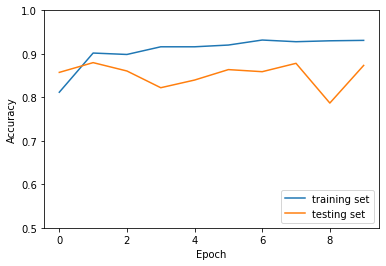

In [18]:
plt.plot(history.history['binary_accuracy'], label='training set')
plt.plot(history.history['val_binary_accuracy'], label = 'testing set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_binacc, test_recall, test_auc = model.evaluate(test_datagen)

20/20 [==============================] - 4s 214ms/step - loss: 0.2947 - binary_accuracy: 0.8734 - recall: 0.9256 - auc: 0.9432


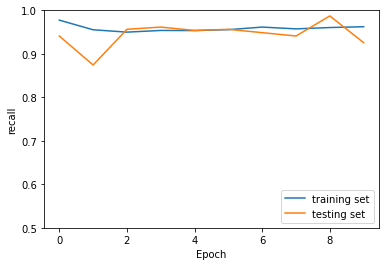

In [19]:
plt.plot(history.history['recall'], label='training set')
plt.plot(history.history['val_recall'], label = 'testing set')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_binacc, test_recall, test_auc = model.evaluate(test_datagen)

20/20 [==============================] - 4s 221ms/step - loss: 0.2947 - binary_accuracy: 0.8734 - recall: 0.9256 - auc: 0.9432


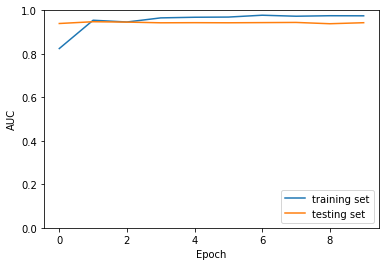

In [20]:
plt.plot(history.history['auc'], label='training set')
plt.plot(history.history['val_auc'], label = 'testing set')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_binacc, test_recall, test_auc = model.evaluate(test_datagen)

In [22]:
model.save('pneumonia_A87_R92_AUC94.h5')

In [11]:
from tensorflow import keras
model = keras.models.load_model('./model/pneumonia_A87_R92_AUC94.h5')

1.0


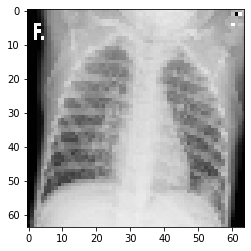

In [12]:
test_iter = iter(test_datagen)
test = test_iter.next()
print(test[1][0])
plt.imshow(test[0][0])

In [13]:
my_test = np.reshape(test[0][0], ( 1, *test[0][0].shape))

In [16]:
my_test.shape

(1, 64, 64, 3)

In [18]:
np.min(my_test)

0.0

In [20]:
np.max(my_test)

1.0

In [22]:
my_test.dtype

dtype('float32')

In [15]:
model.predict(my_test)

array([[0.9435611]], dtype=float32)